In [1]:
import os

In [2]:
os.chdir('..')

In [3]:
pwd

'/Users/A.IVA/Documents/jupyter_notebooks/coursera_and_blogs/rossmann_competition'

In [10]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

### 1 The example from "Bayesian methods for hackers"

In [7]:
data_dir = os.path.join('..', 'data', 'rossmann-store-sales')
count_data = np.loadtxt(os.path.join(data_dir, 'rest', 'txtdata.csv'))

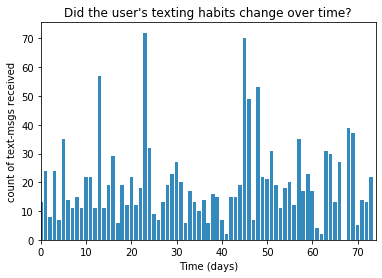

In [11]:
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [12]:
import pymc3 as pm
import theano.tensor as tt

In [14]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean() 
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data-1)
    
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
    
    observation = pm.Poisson("obs", lambda_, observed=count_data)


In [15]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:07<00:00, 4017.06draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [18]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/Users/A.IVA/opt/anaconda3/envs/rossmann/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/A.IVA/opt/anaconda3/envs/rossmann/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


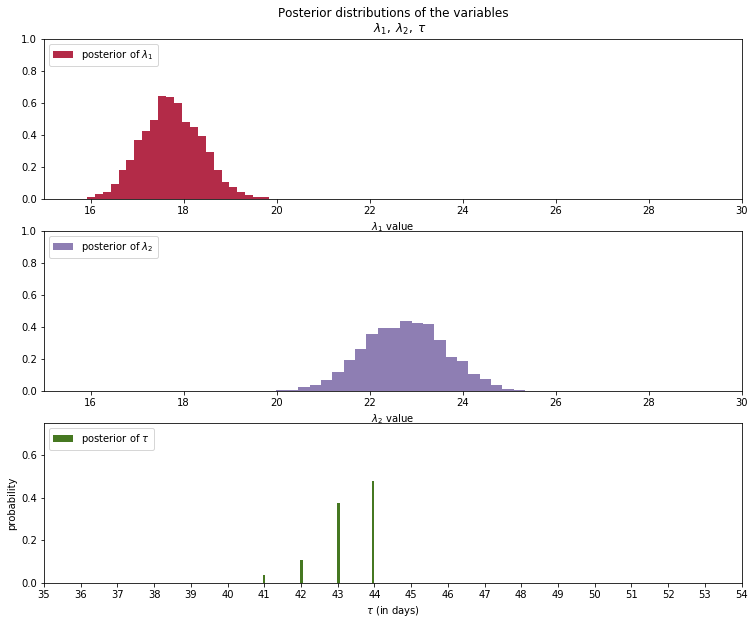

In [19]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

### 2 Apply the same idea to the time series data

In [23]:
import pandas as pd
import datetime

In [1]:
data_dir = os.path.join('..', 'data', 'rossmann-store-sales', 'source')
dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')

df_store = pd.read_csv( os.path.join(data_dir, 'store.csv'))
df_train = pd.read_csv( os.path.join(data_dir, 'train.csv'), parse_dates=[2], low_memory=False)
df_test = pd.read_csv( os.path.join(data_dir, 'test.csv'), parse_dates=[3], date_parser=dateparse)

NameError: name 'os' is not defined

In [56]:
print(df_store.shape, df_train.shape, df_test.shape)
display(df_store.head(2))
display(df_train.head(2))
display(df_test.head(2))

(1115, 10) (1017209, 9) (41088, 8)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


In [58]:
df_store['CompetitionOpenSince'] = df_store[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']]\
    .apply(lambda x: datetime.date(int(x[0]), int(x[1]), 1) if x[0] > 0 and x[1] > 0 else pd.NaT, 1)

df_store['CompetitionOpenSince'] = pd.to_datetime(df_store['CompetitionOpenSince'], format='%Y-%m-%d')
# df_store = df_store.drop(columns=['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'])

In [59]:
df_store.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2008-09-01
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01


In [60]:
tmp = df_train[['Store', 'Date', 'Sales', 'Customers']]\
    .set_index(['Store'])\
    .join(df_store.set_index(['Store'])[['CompetitionOpenSinceMonth', 
                                         'CompetitionOpenSinceYear', 
                                         'CompetitionOpenSince']])\
    .reset_index()

In [63]:
tmp.head(2)

,Store,Date,Sales,Customers,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionOpenSince
0,1,2015-07-31,5263,555,9.0,2008.0,2008-09-01
1,1,2015-07-30,5020,546,9.0,2008.0,2008-09-01


In [67]:
tmp\
    .groupby(by=['Store', 'CompetitionOpenSince', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'],
            as_index=False)\
    .agg({'Sales': 'mean', 'Customers': 'mean'})\
    .sort_values(by=['Store', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'])

,Store,CompetitionOpenSince,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,Sales,Customers
0,1,2008-09-01,2008.0,9.0,3945.704883,467.646497
1,2,2007-11-01,2007.0,11.0,4122.991507,486.045648
2,3,2006-12-01,2006.0,12.0,5741.253715,620.286624
3,4,2009-09-01,2009.0,9.0,8021.769639,1100.057325
4,5,2015-04-01,2015.0,4.0,3867.110403,444.360934
...,...,...,...,...,...,...
756,1108,2004-04-01,2004.0,4.0,4758.597665,488.755839
757,1109,2011-04-01,2011.0,4.0,4043.167546,371.179420
758,1110,2010-09-01,2010.0,9.0,3766.970276,449.000000
759,1111,2014-06-01,2014.0,6.0,4342.968153,373.548832


In [99]:
tmp_2 = tmp[tmp['Store'] == 12].sort_values(by=['Date'])
tmp_2.head(2)

,Store,Date,Sales,Customers,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionOpenSince
11303,12,2013-01-01,0,0,NaN,NaN,NaT
11302,12,2013-01-02,5029,786,NaN,NaN,NaT


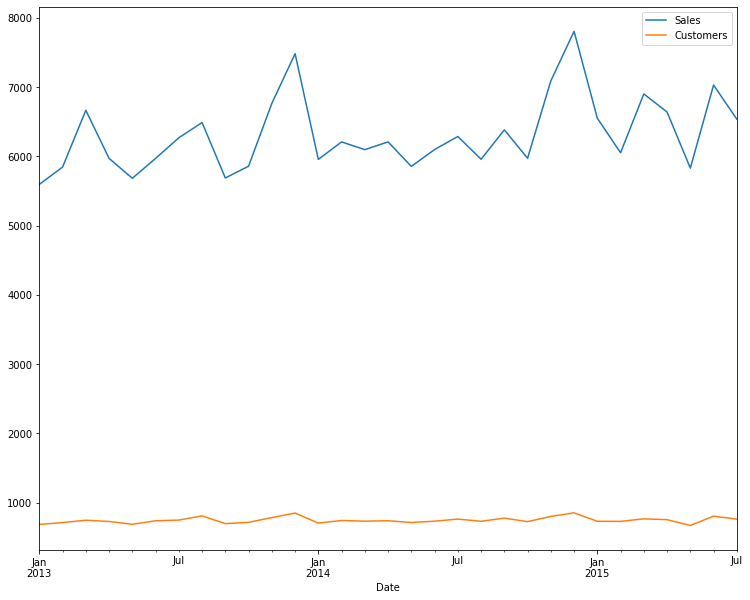

In [100]:
tmp_2 = tmp[tmp['Store'] == 12].set_index(['Date'])[['Sales', 'Customers']].resample('M').mean().plot()

In [ ]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']